In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from cvx_portfolio.costs import TcostModel
# from cvx_portfolio.returns import MarketReturns, AlphaSource
# from cvx_portfolio.simulator import MarketSimulator
# from cvx_portfolio.policies import SinglePeriodOpt, Hold
from cvx_portfolio.data import generate_alpha_signal, series_factor_model_covariance
# from cvx_portfolio.risks import EmpSigma, FactorModelSigma
# from cvx_portfolio.constraints import LeverageLimit  


# plotdir = '../portfolio/plots/'
datadir= '../equity_data_tool/'

In [41]:
def factor_model_covariance(returns, variance_explained=.75):
    """Compute factor model given a returns dataframe.
    
    Derived from the procedure in 
    https://faculty.washington.edu/ezivot/research/factormodellecture_handout.pdf
    
    The risk model is given by 
    $$ F^T \Sigma_{factor} F + \diag(\sigma^2_{idyo}) $$
    
    Args:
        - returns: DataFrame of dimension T x N
        - variance_explained: float in [0,1], how much empirical variance 
                              we want the factor model to explain
    
    Returns:
        - factor_returns: DataFrame of dimension T x n_fact
        - sigma_factor: DataFrame of dimension n_fact x n_fact
        - F: DataFrame of dimension n_fact x N
        - sigma2_idyo: Series of dimension N
    """
    T,N = returns.shape
    returns_demeaned=returns-returns.mean()
    u,s,v = np.linalg.svd(returns_demeaned)
    nfact = ((s**2/sum(s**2)).cumsum()>=variance_explained).nonzero()[0][0]
    factor_returns = pd.DataFrame(index=returns.index, data=u[:, :nfact])
    factor_sigma_sqrt = pd.DataFrame(np.diag(s[:nfact]))
    F = pd.DataFrame(columns=returns.columns, data=v[:nfact, :])
    explained_returns = pd.DataFrame(index=returns.index, columns=returns.columns,
                 data=factor_returns.values @ factor_sigma_sqrt.values @ F.values)
    
    sigma2_idyo = (returns_demeaned - explained_returns).var()
    sigma_factor = factor_sigma_sqrt**2/(T-1)

    return factor_returns, sigma_factor, F, sigma2_idyo

def series_factor_model_covariance(returns, variance_explained=.75, freq='MS',
                                    lookback_periods = 24):
    period_starts = pd.date_range(start=returns.index[0],
                        end=returns.index[-1], freq='MS')

    exposures, factor_sigma, idyos = {}, {},{}
    for i in range(lookback_periods, len(period_starts)):
        t = period_starts[i]
        used_returns = returns.loc[(returns.index < period_starts[i])&
                        (returns.index >= period_starts[i-lookback_periods])]
        factor_returns, sigma_factor, F, sigma2_idyo = factor_model_covariance(used_returns,
                                                                variance_explained=variance_explained)
        exposures[t]=F
        factor_sigma[t]=sigma_factor
        idyos[t]=sigma2_idyo
    
    return pd.Panel(exposures).fillna(value=0), pd.Panel(factor_sigma).fillna(value=0), pd.DataFrame(idyos).T

## Download data using ee103 code (to be integrated) 

In [42]:
sigmas=pd.read_csv(datadir+'sigmas.txt',index_col=0,parse_dates=[0])
returns=pd.read_csv(datadir+'returns.txt',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.txt',index_col=0,parse_dates=[0])
prices=pd.read_csv(datadir+'prices.txt',index_col=0,parse_dates=[0])

In [43]:
exposures_pan, factor_sigma_pan, idyos_df = \
        series_factor_model_covariance(returns, variance_explained=.75, freq='MS',
                                        lookback_periods = 24)

In [44]:
exposures_pan.ix[0]

,HRS,IPG,TGT,RHT,AMG,LOW,ESS,EQT,APD,NEE,...,DD,MU,SCG,PPL,ETN,HP,AAPL,IP,BSX,USDOLLAR
0,-0.082339,-0.123918,-0.100869,-0.093756,-0.148710,-0.095963,-0.116089,-0.101871,-0.094023,-0.068061,...,-0.091266,-0.129080,-0.053300,-0.064073,-0.082239,-0.117716,-0.086775,-0.105902,-0.082466,-0.000010
1,0.071045,-0.000145,-0.041282,0.035118,-0.138899,-0.042504,-0.082240,0.162334,0.086589,0.120226,...,0.040262,0.010422,0.068641,0.095906,0.073859,0.224067,0.051246,0.039281,0.098423,0.000029
2,-0.028444,0.011026,-0.020942,-0.017156,-0.119293,-0.018887,-0.084685,0.003965,-0.028263,0.125027,...,-0.009761,-0.003004,0.103067,0.089497,-0.035209,-0.065303,-0.068573,-0.019938,0.139440,-0.000022
3,0.002837,0.075356,0.123878,0.079343,-0.049356,0.136944,0.186056,-0.059441,-0.057799,0.079474,...,0.005308,-0.080880,0.063033,0.063917,-0.009593,-0.237675,-0.031089,-0.003914,0.121384,-0.000121
4,-0.008440,-0.141584,-0.025851,0.119192,0.171932,0.017178,-0.094293,-0.012553,-0.016474,-0.053418,...,-0.025146,0.428917,-0.023060,-0.051605,-0.056164,0.062483,0.008721,-0.009840,0.182413,-0.000059
5,0.008220,0.022242,0.079732,-0.006545,-0.019178,0.082804,-0.060379,-0.153875,0.024299,-0.035091,...,-0.006669,0.147289,-0.015002,-0.065860,0.057191,-0.147110,0.020350,-0.006257,0.025573,0.000029
6,-0.016555,-0.191557,0.016039,-0.116026,-0.053018,0.089886,-0.020716,0.085257,-0.019877,0.062874,...,-0.016704,0.067947,0.036120,0.079694,-0.030826,0.149264,-0.001632,-0.022534,-0.035198,-0.000076
7,0.024936,-0.196764,0.114078,0.027772,0.173884,0.057684,-0.032116,-0.013541,0.032688,-0.070478,...,0.002256,-0.614004,0.001300,-0.054726,0.072874,-0.043477,0.091864,0.013776,-0.067698,0.000035
8,-0.084802,-0.161284,-0.040455,-0.050286,0.041679,0.020558,0.155663,0.083343,0.014183,0.057861,...,0.006749,0.098770,0.041206,0.038490,-0.027730,0.127467,-0.219936,-0.052684,0.177849,-0.000110
9,0.014409,0.268915,0.087914,-0.019892,-0.107778,0.085601,-0.034645,0.027596,-0.042224,-0.022802,...,-0.043237,-0.083598,-0.048673,-0.003420,-0.010835,0.035789,-0.109649,0.063195,-0.014143,0.000040


In [79]:
exposures = pd.DataFrame(index=returns.columns, data=np.dot(np.linalg.pinv(factor_returns), returns).T)

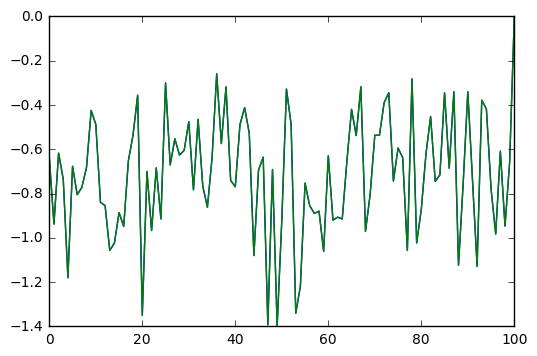

In [96]:
plt.plot(exposures[0].values)
plt.plot(s[0]*v[0,:])

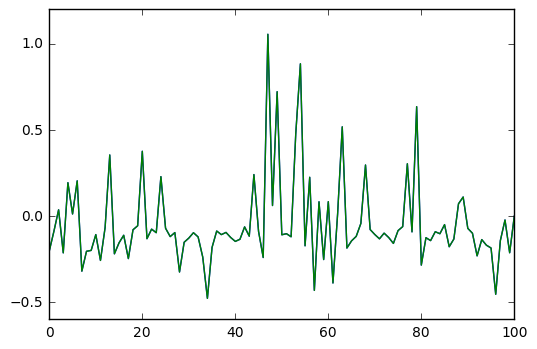

In [97]:
plt.plot(exposures[1].values)
plt.plot(s[1]*v[1,:])

In [44]:
factor_returns = pd.DataFrame(index=returns.index, u[:,:10])

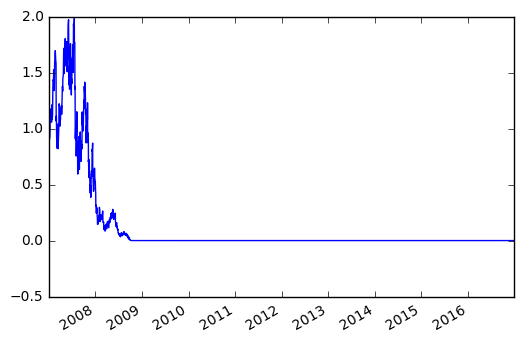

In [49]:
def factor_model_covariance(returns, variance_explained=.75):
    """Compute factor model given a returns dataframe.
    
    Derived from the procedure in 
    https://faculty.washington.edu/ezivot/research/factormodellecture_handout.pdf
    """
    u,s,v = np.linalg.svd(returns)
    nfact = ((s**2/sum(s**2)).cumsum()>=variance_explained).nonzero()[0][0]
    factor_returns = pd.DataFrame(index=returns.columns, data=u[:, :nfact])
    factor_sigma = pd.DataFrame(np.diag(s[:nfact]))
    
    reconst = exposures.values @ factor_sigma.values @ exposures.values.T
    idyos=pd.Series(data=np.diag(fullcov) - np.diag(reconst),
                    index = returns.columns)
    assert min(np.linalg.eigh(reconst + np.diag(idyos))[0]) > 0.
    return factor_returns, factor_sigma, exposures.T, idyos

In [30]:
factor_returns = pd.DataFrame(index=returns.index, data=u[:,:10])

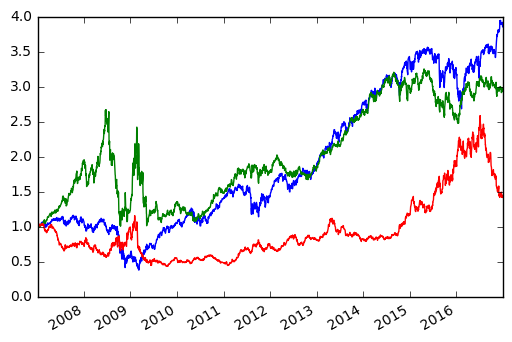

In [33]:
(1-pd.DataFrame(index=returns.index, data=u)[0]).cumprod().plot()
(1-pd.DataFrame(index=returns.index, data=u)[1]).cumprod().plot()
(1-pd.DataFrame(index=returns.index, data=u)[2]).cumprod().plot()

#(1+returns.mean(1)).cumprod().plot()

In [17]:
result_df.applymap(lambda x: x.sharpe_ratio)

gamma_tcost,0.0,30.0,35.0,40.0,45.0
gamma_risk,,,,,
0.0,-2.008087,1.094965,1.062896,0.976725,0.831540
0.5,-2.032906,1.083158,1.063718,0.963870,0.821546
1.0,-2.010054,1.077109,1.070044,0.950258,0.811963
10.0,-2.589782,1.028322,0.848869,0.713010,0.663029


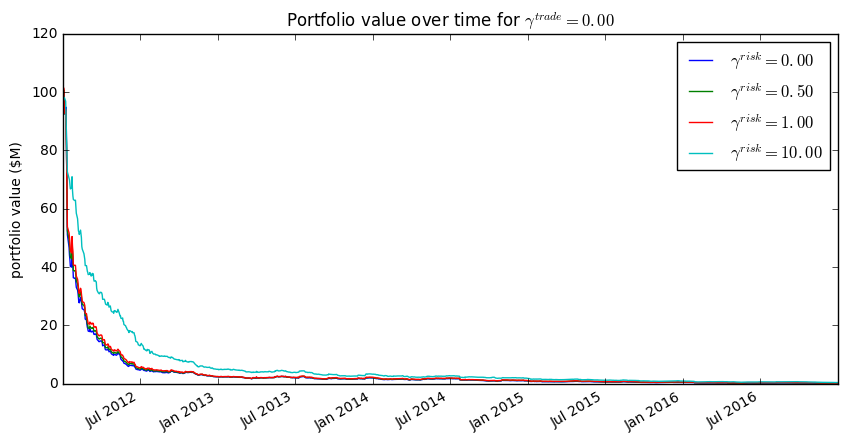

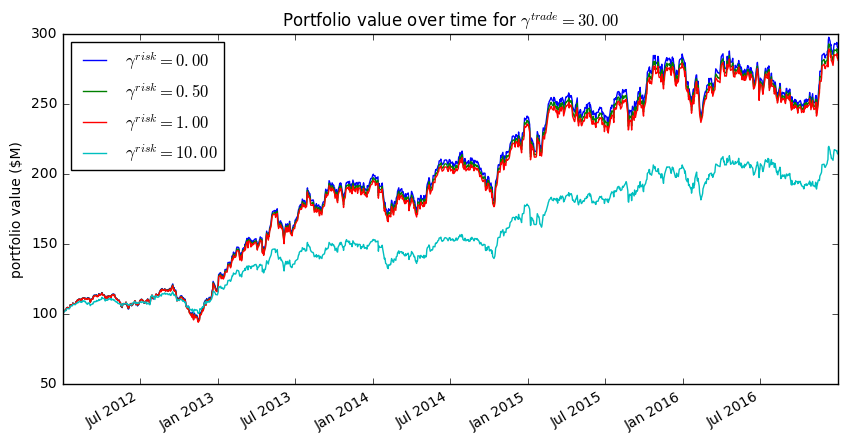

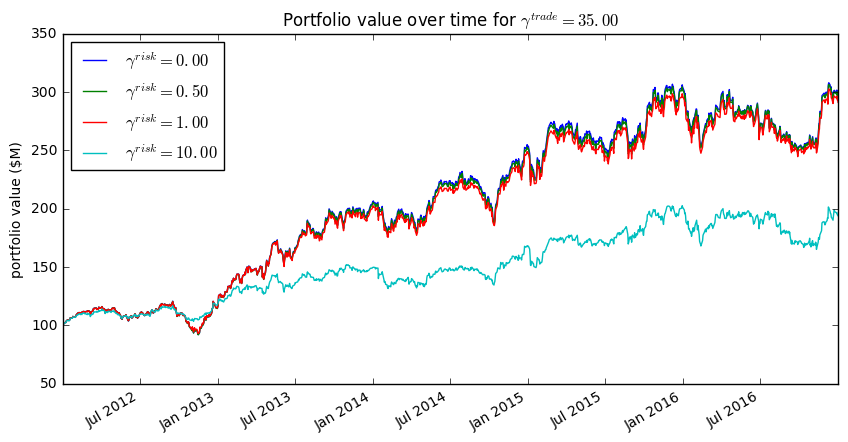

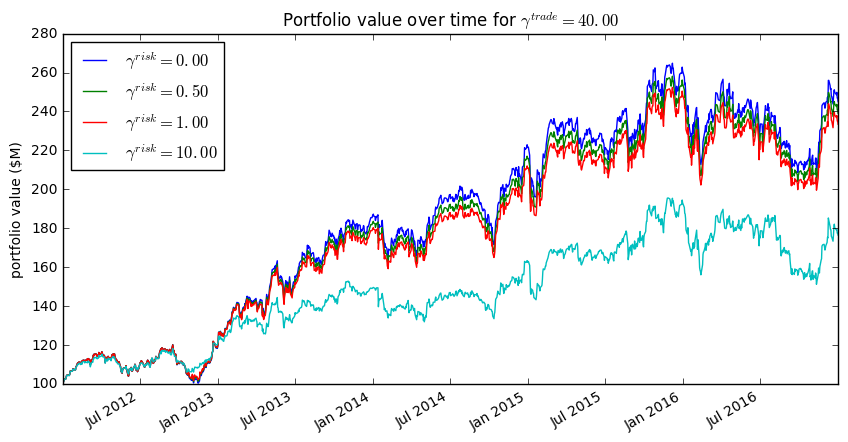

In [18]:
for i in range(4):
    gamma_tcost = gamma_tcosts[i]
    plt.figure(figsize=(10,5))
    [(results[(i, gamma_tcost)].v/1E6).plot(label='$\gamma^{risk} = %.2f$'%i) for i in gamma_risks]
    plt.legend(loc='upper right' if i==0 else 'upper left')
    plt.ylabel('portfolio value (\$M)')
    plt.title('Portfolio value over time for $\gamma^{trade} = %.2f$'%gamma_tcost)
    plt.savefig(plotdir+'spo_valueintime_gammatrade%d.png'%i)

## Other diagnostics

([0.0, 0.5, 1.0, 10.0], 0.0)

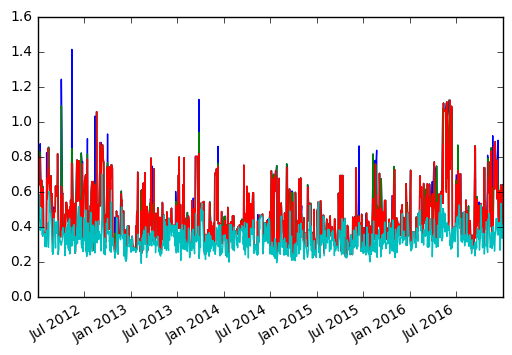

In [19]:
gamma_tcost = gamma_tcosts[0]
[(np.sqrt(250)*np.sqrt(results[(i, gamma_tcost)].policy_FactorModelSigma)).plot() for i in gamma_risks]
gamma_risks, gamma_tcost

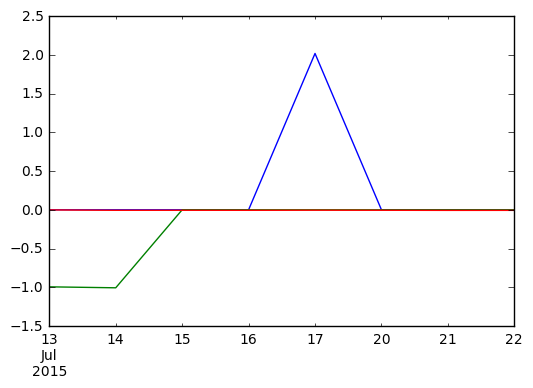

In [20]:
gamma_tcost = gamma_tcosts[0]
index=results[(gamma_risks[0], gamma_tcost)].w.index
results[(gamma_risks[0], gamma_tcost)].w.loc[(index>'2015-07-10')&(index<'2015-07-23'), 
                                             ['LOW','BSX','USDOLLAR']].plot(legend=False)


In [21]:
results[(gamma_risks[0], gamma_tcost)].w.loc[(index>'2015-07-10')&(index<'2015-07-23'), 
                                             ['LOW','BSX','USDOLLAR']]

,LOW,BSX,USDOLLAR
2015-07-13,1.294914e-09,-9.940967e-01,-0.001610
2015-07-14,2.133529e-08,-1.006471e+00,-0.006471
2015-07-15,1.335671e-09,-3.792499e-08,-0.006242
2015-07-16,1.492127e-08,-2.806662e-09,-0.006690
2015-07-17,2.017150e+00,-1.121279e-06,-0.005391
2015-07-20,4.934828e-10,-9.877396e-09,-0.006219
2015-07-21,7.513982e-11,-1.714869e-10,-0.007490
2015-07-22,7.092626e-12,-1.939175e-10,-0.007314


In [22]:
results[(gamma_risks[0], gamma_tcost)].u.loc[(index>'2015-07-10')&(index<'2015-07-23'), 
                                             ['LOW','BSX','USDOLLAR']]

,LOW,BSX,USDOLLAR
2015-07-13,1.168206e-02,-3489.341847,-2849.036868
2015-07-14,-1.175317e-02,591091.361343,165.585428
2015-07-15,7.744585e-03,0.020472,-179.219184
2015-07-16,1.140319e+06,-0.624135,768.360913
2015-07-17,-1.139651e+06,0.627966,-437.380067
2015-07-20,-2.322841e-04,0.005432,-877.024082
2015-07-21,-3.969088e-05,-0.000011,199.981617
2015-07-22,1.193697e-05,0.000120,297.257245


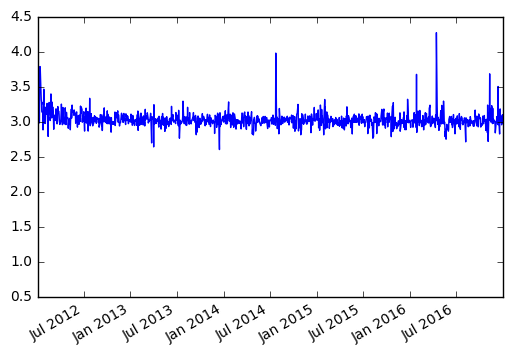

In [23]:
results[(gamma_risks[0], gamma_tcost)].leverage.plot()

In [24]:
alpha_model.alpha_data.loc[(index>'2015-07-10')&(index<'2015-07-23'), 
                                             ['LOW','BSX','USDOLLAR']]

,LOW,BSX,USDOLLAR
2010-07-12,-0.001058,-0.003478,0.000006
2010-07-13,-0.000734,-0.001066,0.000006
2010-07-14,0.010111,0.000814,0.000006
2010-07-15,0.010701,0.007348,0.000006
2010-07-16,0.005035,0.005868,0.000006
2010-07-19,0.004433,0.003323,0.000007
2010-07-20,-0.001957,-0.001762,0.000006
2010-07-21,-0.009523,0.000303,0.000006


In [25]:
returns.loc[(index>'2015-07-10')&(index<'2015-07-23'), 
                                             ['LOW','BSX','USDOLLAR']]

,LOW,BSX,USDOLLAR
2010-07-12,-0.003426,-0.001548,0.000006
2010-07-13,0.039290,0.007752,0.000006
2010-07-14,-0.013710,0.003077,0.000006
2010-07-15,0.000479,0.010740,0.000006
2010-07-16,-0.040230,-0.072840,0.000006
2010-07-19,0.000000,0.000000,0.000007
2010-07-20,0.020070,0.026190,0.000006
2010-07-21,-0.017220,-0.047850,0.000006


In [26]:
sigmas.loc[(index>'2015-07-10')&(index<'2015-07-23'), 
                                             ['LOW','BSX','USDOLLAR']]

,LOW,BSX,USDOLLAR
Date,,,
2010-07-09,0.010270,0.011590,NaN
2010-07-12,0.009512,0.007740,NaN
2010-07-13,0.019600,0.007669,NaN
2010-07-14,0.010670,0.008423,NaN
2010-07-15,0.010740,0.016620,NaN
2010-07-16,0.019240,0.037120,NaN
2010-07-19,0.007727,0.013690,NaN
2010-07-20,0.019100,0.019140,NaN


([0.0, 0.5, 1.0, 10.0], 0.0)

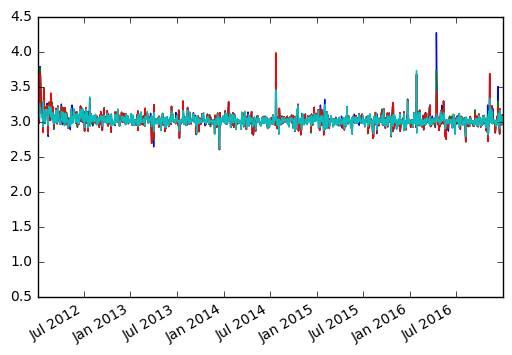

In [27]:
[results[(i, gamma_tcosts[0])].leverage.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[0]

([0.0, 0.5, 1.0, 10.0], 30.0)

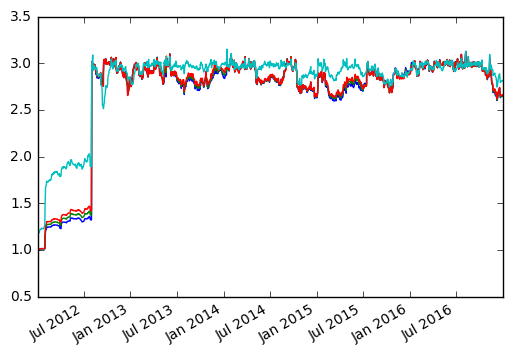

In [28]:
[results[(i, gamma_tcosts[1])].leverage.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[1]

([0.0, 0.5, 1.0, 10.0], 35.0)

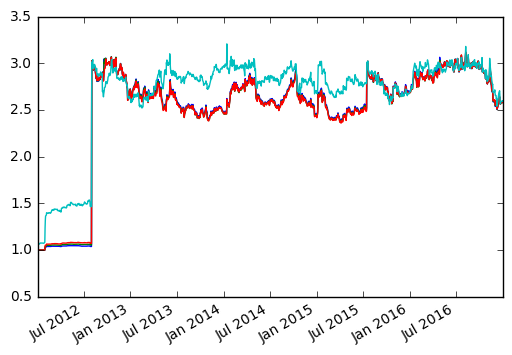

In [29]:
[results[(i, gamma_tcosts[2])].leverage.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[2]

([0.0, 0.5, 1.0, 10.0], 35.0)

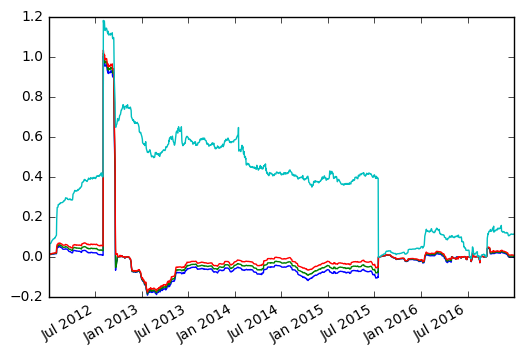

In [30]:
[results[(i, gamma_tcosts[2])].w.USDOLLAR.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[2]

([0.0, 0.5, 1.0, 10.0], 35.0)

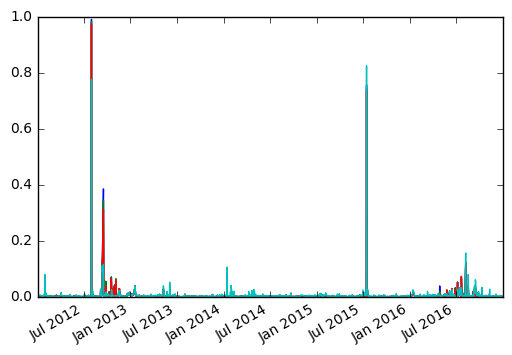

In [31]:
[results[(i, gamma_tcosts[2])].turnover.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[2]

In [32]:
res.turnover.plot()
res.policy_TcostModel.sum(1).plot(secondary_y=True)

NameError: name 'res' is not defined

In [ ]:
res.policy_TcostModel.sum(1).plot()
res.simulator_TcostModel.sum(1).plot(secondary_y=True)

In [ ]:
(res.policy_TcostModel.sum(1)).tail(100).plot(style='.-')
(res.simulator_TcostModel.sum(1)/res.v).tail(100).plot(style='.-')